[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34/CirCor-HS-classification-ICASSP2025/blob/main/model/ModelICASSP2025.ipynb)


# **A Unified Joint Contrastive Triplet Loss with Temporal and Frequency Signal Fusion for Diagnosing Heart Murmurs**

**Authors: Ayushi Pal, Arka Roy, and Udit Satija**

**Coder: Arka Roy and Ayushi Pal**

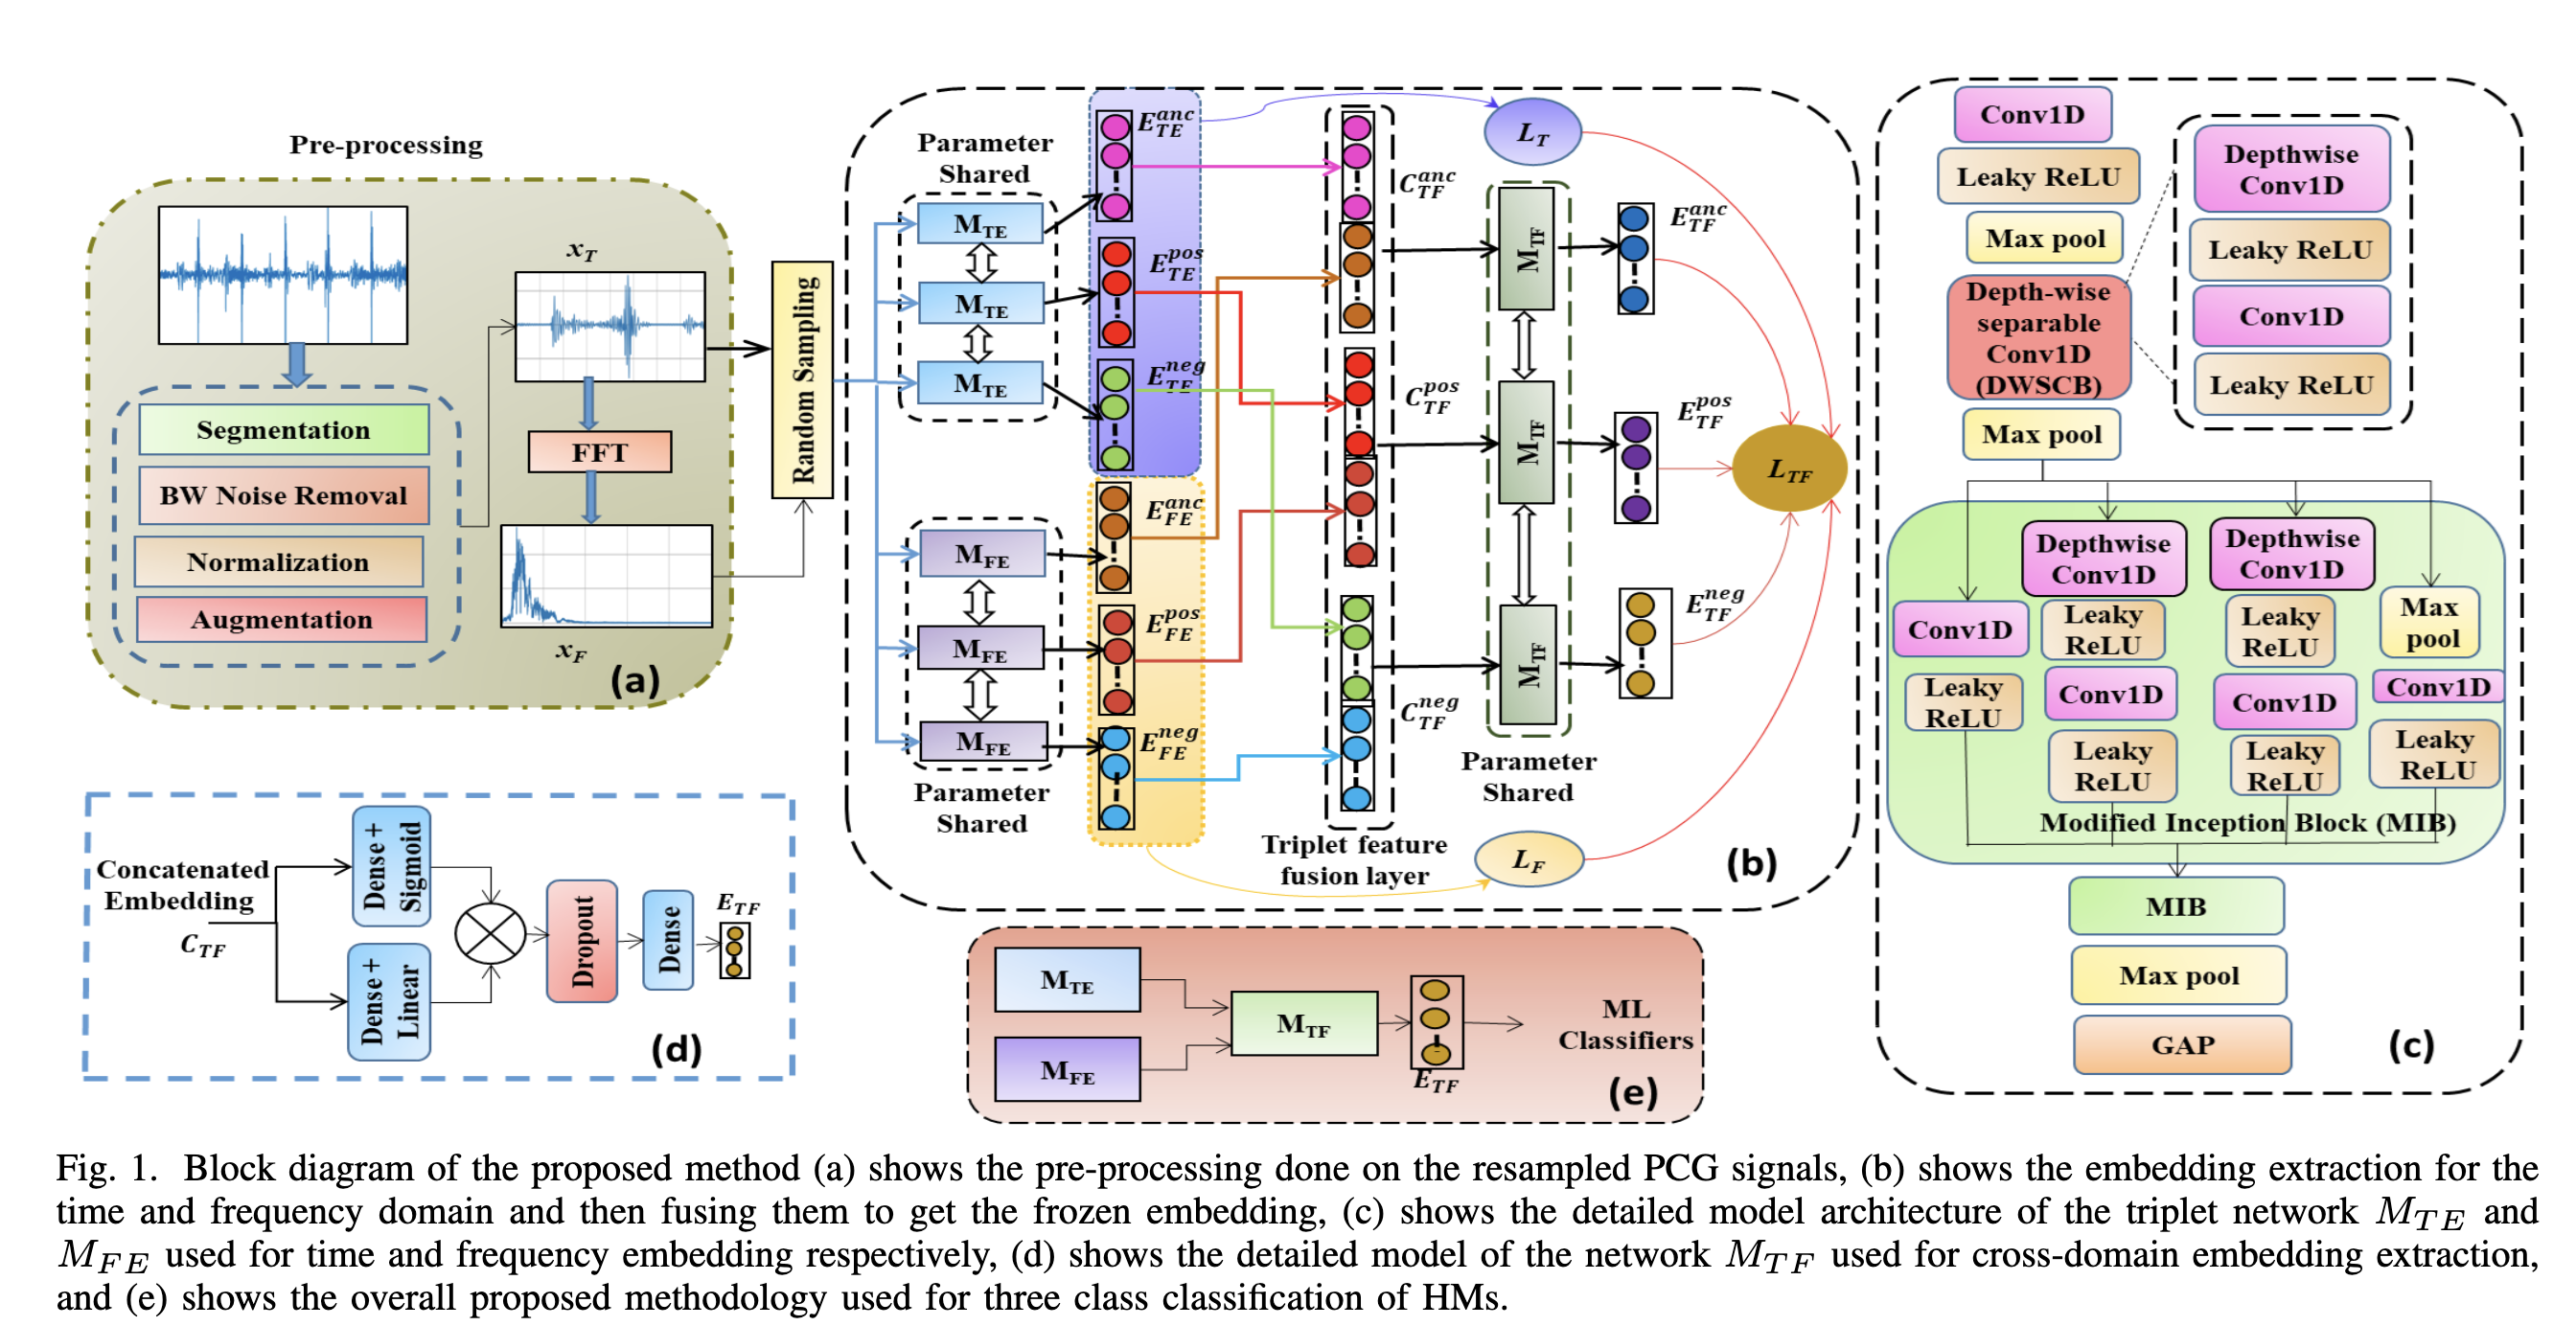

# **Importing Libraries**

In [ ]:
import os
import librosa
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
!pip install patool
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import patoolib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers import Input, Lambda
from keras.regularizers import l2
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import keras

In [ ]:
!pip install mat73
import mat73

# **Load signals and labels**

## **Signal matrix**

In [ ]:
import scipy.io as sio
sig_dict=mat73.loadmat('/content/drive/MyDrive/Ayushi/Circor_aug_5s.mat')
sig=sig_dict['Circor_aug_5s'];
All_sig=sig.T
All_sig.shape

(48369, 10000)

In [ ]:
All_sigs=np.reshape(All_sig,(All_sig.shape[0],All_sig.shape[1],1))
All_sigs.shape

(48369, 10000, 1)

## **Label array**

In [ ]:
Labels=pd.read_excel("/content/drive/MyDrive/Ayushi/Label_aug_5s.xlsx",header=None)
All_label=np.array(Labels)
All_label.shape

(48369, 1)

## **Visualize the signals and their FFTs**

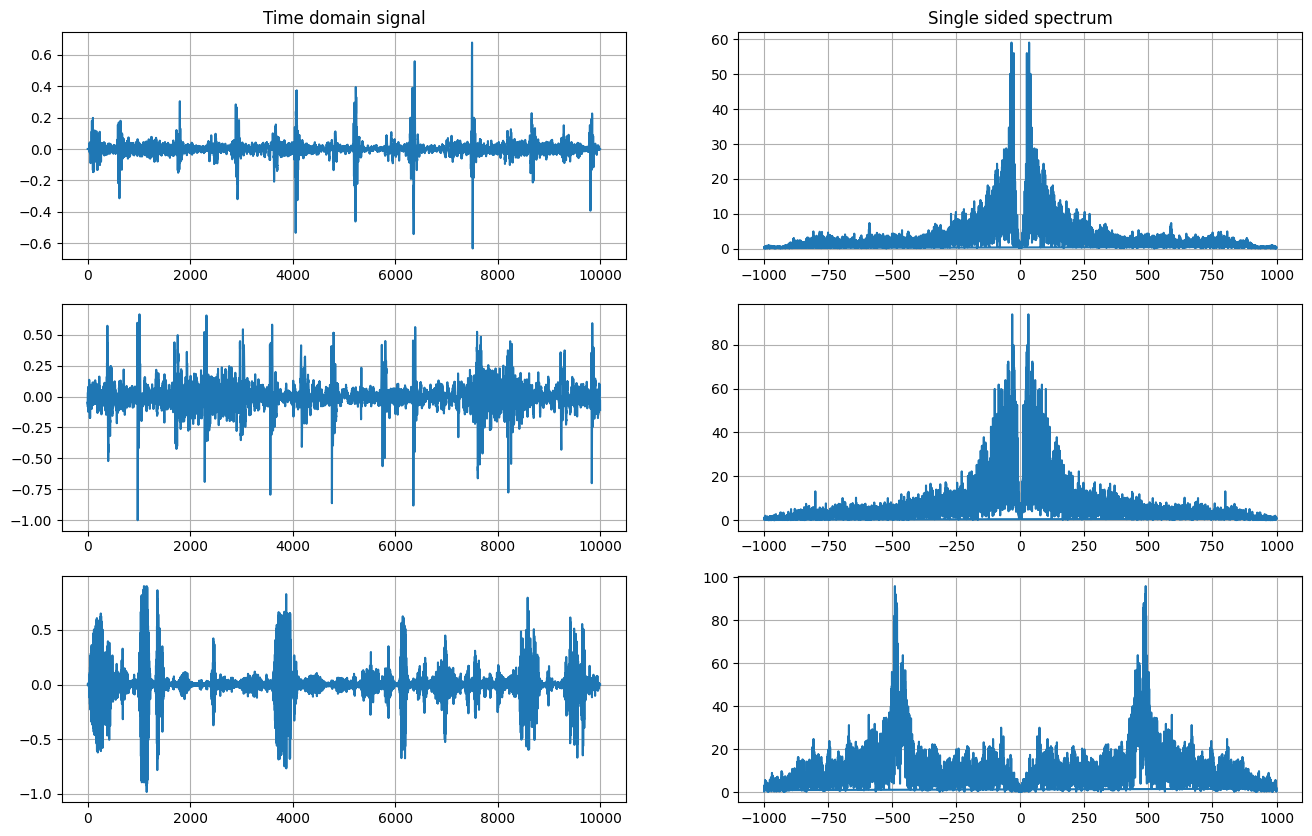

In [ ]:
from scipy import signal
from scipy.fft import fft, fftfreq
NFFT = All_sig.shape[1];
f_s=2000;

Present_sig=All_sig[1,:];
Absent_sig=All_sig[18560,:];
Unknown_sig=All_sig[40020,:];

freqs = fftfreq(len(Present_sig)) * f_s
# apply fft to check spectral content
fft_present=fft(Present_sig,NFFT);fft_absent=fft(Absent_sig,NFFT);fft_Unknown=fft(Unknown_sig,NFFT)

plt.figure(figsize=(16,10))
plt.subplot(321)
plt.plot(Present_sig)
plt.title('Time domain signal')
plt.grid()
plt.subplot(322)
plt.plot(freqs[0:10000], np.abs(fft_present[0:10000]))
plt.title('Single sided spectrum')
plt.grid()

plt.subplot(323)
plt.plot(Absent_sig)
plt.grid()
plt.subplot(324)
plt.plot(freqs[0:10000], np.abs(fft_absent[0:10000]))
plt.grid()

plt.subplot(325)
plt.plot(Unknown_sig)
plt.grid()
plt.subplot(326)
plt.plot(freqs[0:10000], np.abs(fft_Unknown[0:10000]))
plt.grid()

In [ ]:
# Frequency domain data creation
spectrum_data=[]
for i in range (All_sig.shape[0]):
    s=All_sig[i,:];
    fft_s=fft(s,NFFT);
    fft_sf=np.abs(fft_s[0:5000]);
    spectrum_data.append(fft_sf)
spectrum_data=np.array(spectrum_data)
spec_data=np.reshape(spectrum_data,(spectrum_data.shape[0],spectrum_data.shape[1],1))

## **Splitting the dataset**

In [ ]:
from sklearn.model_selection import train_test_split
seed=2
X_time_train1, X_time_test, X_freq_train1, X_freq_test, y_train1, y_test = train_test_split(All_sigs, spec_data, All_label, test_size=0.1,random_state=seed)
X_time_train, X_time_valid, X_freq_train, X_freq_valid, y_train, y_valid = train_test_split(X_time_train1, X_freq_train1, y_train1, test_size=0.1,random_state=seed)

## **Triplet set generation**

In [ ]:
def triplet_generator(time_data,freq_data,label,batch_size):
    x_anchors_time = [];
    x_positives_time = [];
    x_negatives_time = [];

    x_anchors_freq = [];
    x_positives_freq = [];
    x_negatives_freq = [];

    for i in range(0, batch_size):
        # # Randomly select an anchor example
        random_index = random.randint(0, time_data.shape[0] - 1)
        anchor_time = time_data[random_index]
        anchor_freq = freq_data[random_index]
        anchor_label = label[random_index]
        # Randomly select a positive example with the same label as the anchor
        indices_for_pos = np.where(label == anchor_label)[0]
        final_pos_idx=indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]
        indices_for_neg = np.where(label != anchor_label)[0]
        final_neg_idx=indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]
        #indices_for_pos = np.squeeze(np.where(label == anchor_label)); final_pos_idx=indices_for_pos[random.randint(0, len(indices_for_pos) - 1)];
        #indices_for_neg = np.squeeze(np.where(label != anchor_label)); final_neg_idx=indices_for_neg[random.randint(0, len(indices_for_neg) - 1)];

        positive_time = time_data[final_pos_idx];
        negative_time = time_data[final_neg_idx];
        positive_freq = freq_data[final_pos_idx];
        negative_freq = freq_data[final_neg_idx];

        x_anchors_time.append(anchor_time) ;
        x_positives_time.append(positive_time)
        x_negatives_time.append(negative_time)

        x_anchors_freq.append(anchor_freq) ;
        x_positives_freq.append(positive_freq)
        x_negatives_freq.append(negative_freq)

    return np.array(x_anchors_time), np.array(x_positives_time), np.array(x_negatives_time), np.array(x_anchors_freq), np.array(x_positives_freq), np.array(x_negatives_freq)

anchor_time, positive_time, negative_time, anchor_freq, positive_freq, negative_freq=triplet_generator(X_time_train,X_freq_train,y_train,batch_size=1)

In [ ]:
def train_data_generator(time_data,freq_data,label,batch_size):
    while True:
        x_ta, x_tp, x_tn, x_fa, x_fp, x_fn =  triplet_generator(time_data,freq_data,label,batch_size)
        y_t = np.zeros((batch_size, 1)).astype("float32")
        yield ([x_ta,x_tp, x_tn,x_fa,x_fp, x_fn],y_t)

## **Visualize the triplet set: Anchor, Positive and Negetive class data**

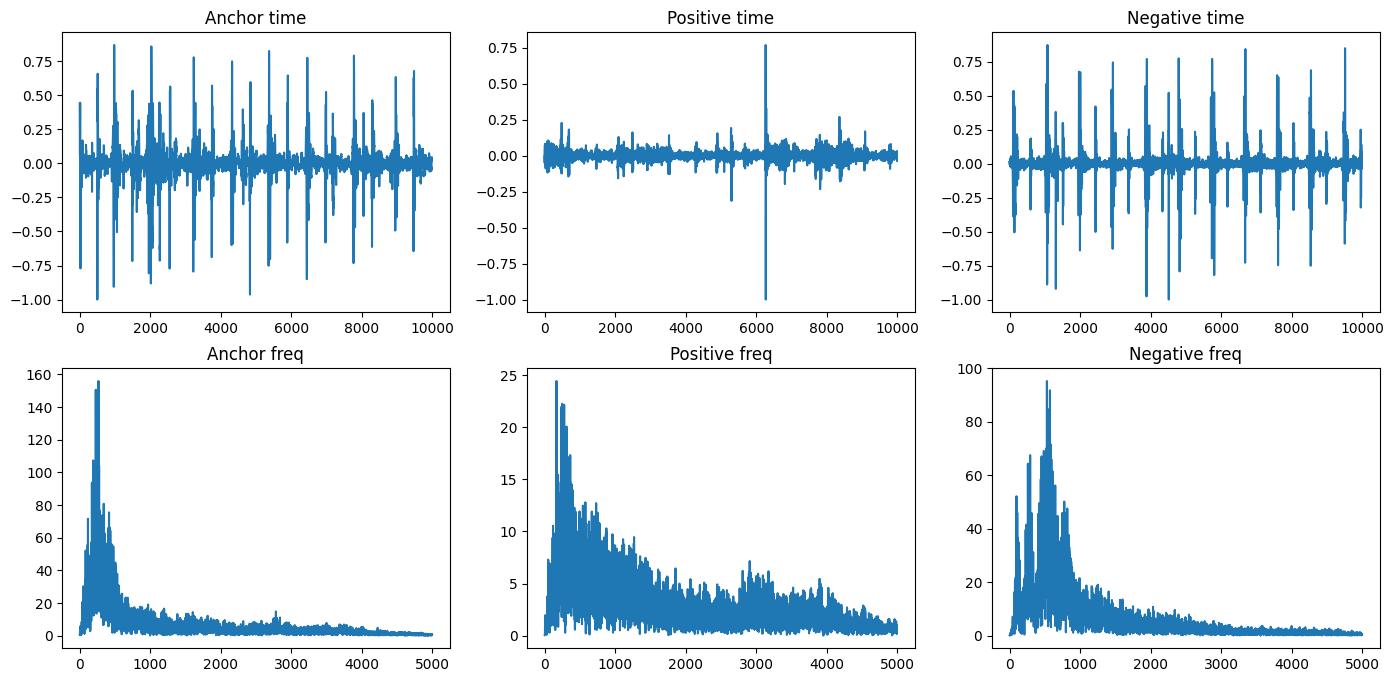

In [ ]:
def plot_triplet(anchor_time, positive_time, negative_time, anchor_freq, positive_freq, negative_freq):

    fig, axs = plt.subplots(2, 3, figsize=(17, 8))

    axs[0, 0].plot(anchor_time.reshape(10000,1))
    axs[0,0].set_title('Anchor time')

    axs[0,1].plot(positive_time.reshape(10000,1))
    axs[0,1].set_title('Positive time')

    axs[0,2].plot(negative_time.reshape(10000,1))
    axs[0,2].set_title('Negative time')

    axs[1,0].plot(anchor_freq.reshape(5000,1))
    axs[1,0].set_title('Anchor freq')

    axs[1,1].plot(positive_freq.reshape(5000,1))
    axs[1,1].set_title('Positive freq')

    axs[1,2].plot(negative_freq.reshape(5000,1))
    axs[1,2].set_title('Negative freq')
    plt.show()
# Visualize one set of data
anchor_time, positive_time, negative_time, anchor_freq, positive_freq, negative_freq=triplet_generator(X_time_train,X_freq_train,y_train,batch_size=1)
plot_triplet(anchor_time[0], positive_time[0], negative_time[0],anchor_freq[0], positive_freq[0], negative_freq[0])

# **Proposed Joint Contrastive Embedding Learning**

## **Define the Neural Network Architectures**

In [ ]:
def CNN_model(dim):

    def block(x, filters, reps):
        for _ in range(reps):
            # for low-level features
            t1 = Conv1D(filters[0], kernel_size = 3)(x)
            t1 = LeakyReLU()(t1)

            # for mid-level features
            t2 = DepthwiseConv1D(kernel_size = 3, strides = 1, padding = 'same')(x)
            t2 = LeakyReLU()(t2)
            t2 = Conv1D(filters[1], kernel_size = 3)(t2)
            t2 = LeakyReLU()(t2)

            # for high-level features
            t3 = DepthwiseConv1D(kernel_size = 5, strides = 1, padding = 'same')(x)
            t3 = LeakyReLU()(t3)
            t3 = Conv1D(filters[2], kernel_size = 3)(t3)
            t3 = LeakyReLU()(t3)

            # for most-significant features
            t4 = MaxPool1D(pool_size = 3, strides = 1, padding = 'same')(x)
            t4 = Conv1D(filters[3], kernel_size = 3)(t4)
            t4 = LeakyReLU()(t4)

            x = Concatenate()([t1, t2, t3, t4])

        return x


    input = Input(shape = dim)

    k = 32

    x = Conv1D(filters = k, kernel_size = 5, strides = 2, padding = 'same')(input)
    x = LeakyReLU()(x)
    x = MaxPool1D(pool_size = 2, strides = 2, padding = 'same')(x)

    x = DepthwiseConv1D(kernel_size = 3, strides = 1, padding = 'same')(x)
    x = LeakyReLU()(x)
    x = Conv1D(filters = 2*k, kernel_size =1)(x)
    x = LeakyReLU()(x)
    x = MaxPool1D(pool_size = 2, strides = 2)(x)

    x = block(x, [k, k, k, k], reps = 2)
    x = MaxPool1D(pool_size = 2, strides = 2)(x)

    output = GlobalAveragePooling1D()(x)

    model = Model(inputs = input, outputs = output)
    return model

def merdge_model(dim,embsize):
    input = Input(shape = dim)
    x1= Dense(60, 'sigmoid')(input)
    x2= Dense(60,'linear')(input)
    x=Multiply()([x1,x2])
    x = Dropout(0.3)(x)
    output=  Dense(embsize, 'linear')(x)
    model = Model(inputs = input, outputs = output)
    return model

## **Defining $M_{TE}$, $M_{FE}$, $M_{TF}$**

In [ ]:
Time_model=CNN_model(dim=(10000,1))
Freq_model=CNN_model(dim=(5000,1))
Time_frequency_model=merdge_model(dim=(256,),embsize=40)

Time_model.summary()
Freq_model.summary()
Time_frequency_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10000, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 5000, 32)       │            192 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_30            │ (None, 5000, 32)       │              0 │ conv1d_20[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_10          │ (None, 2500, 32)       │              0 │ leaky_re_lu_30[0][0]   │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_10       │ (None, 2500, 32)       │            128 │ max_pooling1d_10[0][0] │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_31            │ (None, 2500, 32)       │              0 │ depthwise_conv1d_10[0… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 2500, 64)       │          2,112 │ leaky_re_lu_31[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_32            │ (None, 2500, 64)       │              0 │ conv1d_21[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_11          │ (None, 1250, 64)       │              0 │ leaky_re_lu_32[0][0]   │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_11       │ (None, 1250, 64)       │            256 │ max_pooling1d_11[0][0] │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_12       │ (None, 1250, 64)       │            384 │ max_pooling1d_11[0][0] │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_34            │ (None, 1250, 64)       │              0 │ depthwise_conv1d_11[0… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_36            │ (None, 1250, 64)       │              0 │ depthwise_conv1d_12[0… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 1250, 64)       │              0 │ max_pooling1d_11[0][0] │
│ (MaxPooling1D)       

 Total params: 78,336 (306.00 KB)

 Trainable params: 78,336 (306.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 5000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_30 (Conv1D)        │ (None, 2500, 32)       │            192 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_45            │ (None, 2500, 32)       │              0 │ conv1d_30[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_15          │ (None, 1250, 32)       │              0 │ leaky_re_lu_45[0][0]   │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_15       │ (None, 1250, 32)       │            128 │ max_pooling1d_15[0][0] │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_46            │ (None, 1250, 32)       │              0 │ depthwise_conv1d_15[0… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_31 (Conv1D)        │ (None, 1250, 64)       │          2,112 │ leaky_re_lu_46[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_47            │ (None, 1250, 64)       │              0 │ conv1d_31[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_16          │ (None, 625, 64)        │              0 │ leaky_re_lu_47[0][0]   │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_16       │ (None, 625, 64)        │            256 │ max_pooling1d_16[0][0] │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_17       │ (None, 625, 64)        │            384 │ max_pooling1d_16[0][0] │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_49            │ (None, 625, 64)        │              0 │ depthwise_conv1d_16[0… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_51            │ (None, 625, 64)        │              0 │ depthwise_conv1d_17[0… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_17          │ (None, 625, 64)        │              0 │ max_pooling1d_16[0][0] │
│ (MaxPooling1D)       

 Total params: 78,336 (306.00 KB)

 Trainable params: 78,336 (306.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 60)             │         15,420 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 60)             │         15,420 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 60)             │              0 │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60)             │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 40)             │          2,440 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,280 (130.00 KB)

 Trainable params: 33,280 (130.00 KB)

 Non-trainable params: 0 (0.00 B)

## **Creating joing triplet nets**

In [ ]:
time_ip_a = Input((10000,1))
time_ip_p = Input((10000,1))
time_ip_n = Input((10000,1))

fft_ip_a = Input((5000,1))
fft_ip_p = Input((5000,1))
fft_ip_n = Input((5000,1))

tA_embs = Time_model(time_ip_a)
tP_embs = Time_model(time_ip_p)
tN_embs = Time_model(time_ip_n)

fA_embs = Freq_model(fft_ip_a)
fP_embs = Freq_model(fft_ip_p)
fN_embs = Freq_model(fft_ip_n)

tfA_cat = tf.keras.layers.concatenate([tA_embs, fA_embs], axis=1)
tfP_cat = tf.keras.layers.concatenate([tP_embs, fP_embs], axis=1)
tfN_cat = tf.keras.layers.concatenate([tN_embs, fN_embs], axis=1)

tfA_embs = Time_frequency_model(tfA_cat)
tfP_embs = Time_frequency_model(tfP_cat)
tfN_embs= Time_frequency_model(tfN_cat)

output = tf.keras.layers.concatenate([tfA_embs, tfP_embs, tfN_embs], axis=1)
TimeFreq_triplet_model = Model([time_ip_a, time_ip_p, time_ip_n, fft_ip_a, fft_ip_p, fft_ip_n], output)

TimeFreq_triplet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 10000, 1)]           0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 10000, 1)]           0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                            

## **Model Visualization**

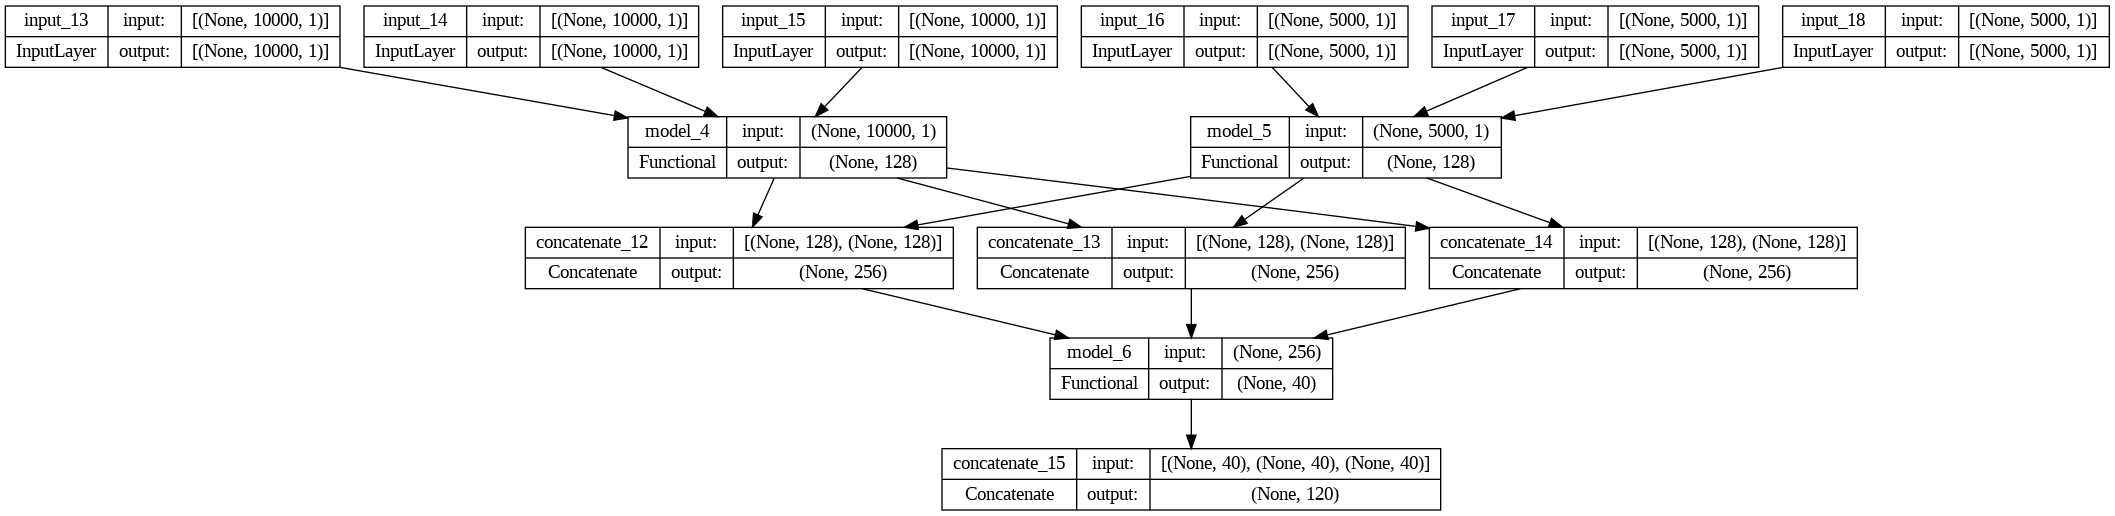

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(TimeFreq_triplet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **Simulation Parameters**

In [ ]:
alpha = 0.2
embsize=40
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:embsize], y_pred[:,embsize:2*embsize], y_pred[:,2*embsize:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [ ]:
batch_size = 128
epochs = 150
steps_per_epoch = int(X_time_train.shape[0]/batch_size)
opt =tf.keras.optimizers.Adam(learning_rate=0.001)
TimeFreq_triplet_model.compile(loss=triplet_loss, optimizer=opt)

## **Train the model**

In [ ]:
history =TimeFreq_triplet_model.fit(train_data_generator(X_time_train,X_freq_train,y_train,batch_size),steps_per_epoch=steps_per_epoch,epochs=epochs, verbose=1,validation_data=train_data_generator(X_time_valid,X_freq_valid,y_valid,batch_size),validation_steps=int(X_time_valid.shape[0]/batch_size))

Epoch 1/150
306/306 [==============================] - 203s 609ms/step - loss: 0.2001 - val_loss: 0.1998
Epoch 2/150
306/306 [==============================] - 185s 606ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 3/150
306/306 [==============================] - 186s 606ms/step - loss: 0.2000 - val_loss: 0.1999
Epoch 4/150
306/306 [==============================] - 186s 607ms/step - loss: 0.2000 - val_loss: 0.1999
Epoch 5/150
306/306 [==============================] - 186s 606ms/step - loss: 0.1999 - val_loss: 0.1997
Epoch 6/150
306/306 [==============================] - 186s 606ms/step - loss: 0.2000 - val_loss: 0.1998
Epoch 7/150
306/306 [==============================] - 185s 606ms/step - loss: 0.2001 - val_loss: 0.2001
Epoch 8/150
306/306 [==============================] - 185s 606ms/step - loss: 0.1998 - val_loss: 0.1987
Epoch 9/150
306/306 [==============================] - 185s 606ms/step - loss: 0.1989 - val_loss: 0.1990
Epoch 10/150
306/306 [==============================] -

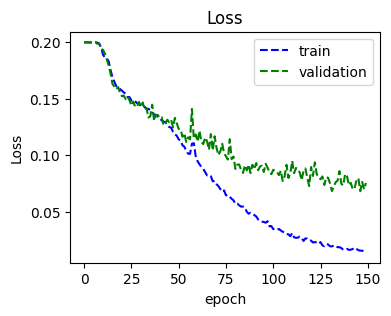

In [ ]:
plt.figure(figsize=(4, 3))
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
# summarize history for loss
plt.plot(training_loss,'b--')
plt.plot(validation_loss,'g--')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='best')
plt.show()

## **Save curves and model weights**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

new_loc='/content/gdrive/MyDrive/Ayushi/Time_freq_triplet/Circor/Model'

# Verify the directory exists, if not, create it
import os
if not os.path.exists(new_loc):
    os.makedirs(new_loc)

# save the plot variables
filepath_tloss=new_loc+'/train_loss.txt'
np.savetxt(filepath_tloss,training_loss)

filepath_vloss=new_loc+'/val_loss.txt'
np.savetxt(filepath_vloss,validation_loss)

Mounted at /content/gdrive


In [ ]:
new_loc='/content/gdrive/MyDrive/Ayushi/Time_freq_triplet/Circor/Model'

from keras.models import model_from_json
joint_model_json = TimeFreq_triplet_model.to_json()
with open(new_loc+"/TimeFreq_triplet_model_circor.json", "w") as json_file:
    json_file.write(joint_model_json)

TimeFreq_triplet_model.save_weights(new_loc+"/TimeFreq_triplet_model_circor.h5")

# **Results**

## **Embedding Visualization**

In [ ]:
def get_final_embeds(X_time,X_freq):
    time_embds=TimeFreq_triplet_model.layers[6].predict(X_time)
    freq_embds=TimeFreq_triplet_model.layers[7].predict(X_freq)
    concatted_embds=np.concatenate([time_embds, freq_embds], axis=1)
    timefreq_embds=TimeFreq_triplet_model.layers[11].predict(concatted_embds)
    return timefreq_embds

Training_embds=get_final_embeds(X_time_train,X_freq_train)
Validation_embds=get_final_embeds(X_time_valid,X_freq_valid)
Test_embds=get_final_embeds(X_time_test,X_freq_test)

152/152 [==============================] - 0s 1ms/step


In [ ]:
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')

train_tsne_embeds = tsne.fit_transform(Training_embds)
valid_tsne_embeds = tsne.fit_transform(Validation_embds)
test_tsne_embeds = tsne.fit_transform(Test_embds)

In [ ]:
def plot_tsne(data,Label_ar,title_plot):
    df = pd.DataFrame()
    df["Labels"] = Label_ar.flatten()  # Flatten Label_ar to make it 1-dimensional
    df["comp-1"] = data[:,0]
    df["comp-2"] = data[:,1]
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df,palette="deep").set(title=title_plot)
    plt.show()

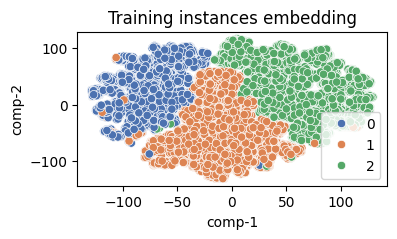

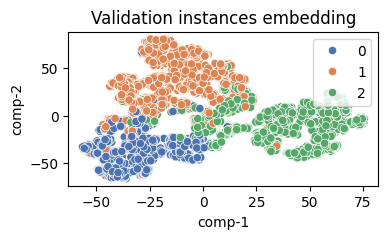

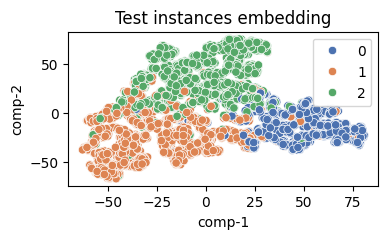

In [ ]:
plt.figure(figsize=(4, 2))
plot_tsne(train_tsne_embeds, y_train,'Training instances embedding')
plt.figure(figsize=(4, 2))
plot_tsne(valid_tsne_embeds, y_valid,'Validation instances embedding')
plt.figure(figsize=(4, 2))
plot_tsne(test_tsne_embeds, y_test,'Test instances embedding')

## **Label prediction using KNN**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Training_embds, y_train)
y_pred = knn.predict(Validation_embds)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)
# Calculate precision
precision = precision_score(y_valid, y_pred, average='weighted')  # 'weighted' for multi-class
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_valid, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_valid, y_pred, average='weighted')
print("F1-score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.8959577400091869


## **Label prediction using SVM**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # Import the SVC class
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Create an instance of the SVC estimator
svm_classifier = SVC()
svm_classifier.fit(Training_embds, y_train)

# Now you can use predict on the instance
y_pred = svm_classifier.predict(Validation_embds)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)
# Calculate precision
precision = precision_score(y_valid, y_pred, average='weighted')  # 'weighted' for multi-class
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_valid, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_valid, y_pred, average='weighted')
print("F1-score:", f1)
# Calculate the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8987138263665595


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(y_valid, y_pred, average='weighted')  # 'weighted' for multi-class
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_valid, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_valid, y_pred, average='weighted')
print("F1-score:", f1)
# Calculate the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Precision: 0.9008385337215145
Recall: 0.8987138263665595
F1-score: 0.8989193567146944


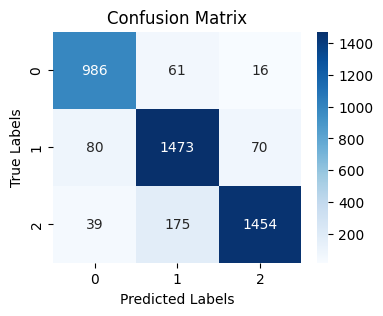

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()